## Repeated lotteries are not fair

Lotteries are a reasonably fair way to allocate scarce resources. One interesting feature of lotteries, however, is that they can quickly become unfair when they happen on a repeated basis.

For instance, suppose we run a lottery with one hundred entrants and seven winners per lottery. If we run the lottery thirty times and count how often each of the hundred entrants won, we can immediately see that some entrants win the lottery a bunch and some don't win it all.

/home/alex/anaconda3/envs/lottery/lib/python3.12/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x7b1a3c3ffe20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


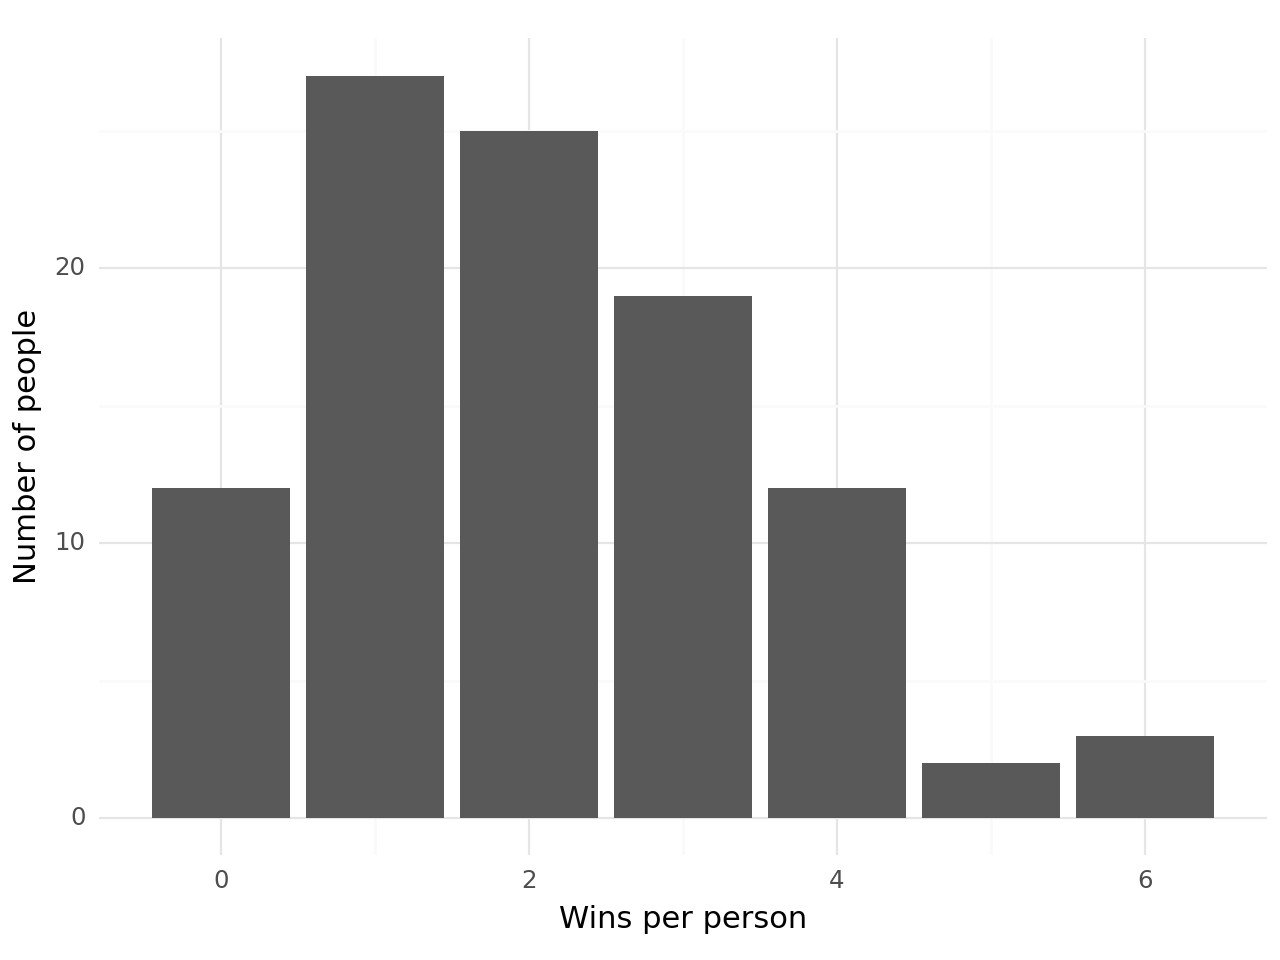

<Figure Size: (640 x 480)>

In [1]:
#| message: false
#| warning: false
#| code-fold: true

import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal

rng = np.random.default_rng(27)

num_entrants = 100
num_winners_per_lottery = 7
num_lotteries = 30

winners = np.zeros((num_entrants, num_lotteries))

for lottery in range(num_lotteries):
    winner_idx = rng.choice(
        num_entrants,
        size=num_winners_per_lottery,
        replace=False
    )
    winners[winner_idx, lottery] = 1

def plot_win_distribution(total_wins: np.array):
    total_wins_df = pd.DataFrame(total_wins, columns=['total_wins'])
    plot =  (
        ggplot(total_wins_df) +
        aes(x='total_wins') +
        geom_bar() +
        labs(
            x='Wins per person',
            y='Number of people'
        ) +
        theme_minimal()
    )
    return plot

plot_win_distribution(winners.sum(axis = 1))

There are three entrants who won six times, but over ten entrants who have never won at all! This system no longer allocates each entrant a similar amount of winning seats^[Unfair outcomes mostly happen when the number of entrants is a small multiple of the number of possible winners. If almost no one wins the lottery (or almost everyone does) repeated winners (or losers) are pretty rare].

Repeated lotteries come up in a number of places, but most intriguingly for recurring events like the New York Marathon or Burning Man, where there are attendance limits.

## Formalizing fairness in repeated lotteries

A while back I started wondering about ways to run repeated lotteries in a fair way, and eventually I reached out to [Bailey Flanigan](http://baileyflanigan.com/), a computer scientist working on fair allocation problems in civic contexts. Less than a day after receiving my email, Bailey sent me several pages of detailed notes on the problem, and suggested a way to formalize fairness in repeated lotteries^[I strongly encourage you to read Bailey's papers if this kind of thing is up your alley. I also want to say that it was incredibly fun to brainstorm back and forth with Bailey, and if you get the chance to work with her at all, I highly recommend it.]. Using her formalization, I sketched out some demo code that runs repeated lotteries in a fair way.

Suppose there is universe $U$ of possible entrants indexed by $i = 1, 2, 3, ...$, and we run repeated lotteries indexed by $t = 1, ..., T$. For each lottery $t$, there are $N_t$ entrants and $K_t$ prizes, or possible winners. In each lottery, we assume each applicant has a score $s_i^t$, which is typically just a binary indicator of whether or not they applied. But you can also run weighted lotteries by allowing $s_i^t$ to be arbitrary positive numbers, so that applicants with higher scores are more likely to selected. 

For instance, in the New York Marathon, we could score entrants according to their past marathon performance to ensure that a number of world-class athletes end up admitted to the event. If entrant $i$ has a score of $s_i^t = 6$ and entrant $j$ has a score of $s_j^t = 2$, then entrant $i$ is $s_i^t / s_j^t = 6 / 2 = 3$ times more likely to win than entrant $j$.

To encode fairness, we allocate each lottery entrant a certain portion of deserved overall winnings in each lottery. When everyone has the same score, everyone is allocated the same portion of the winnings. We then randomly select winners proportional to their allocated share of the winnings. That is, for the $t^{th}$ lottery, we think that entrant $i$ should be probabilistically allocated
$$
\underbrace{\frac{s_i^t}{\sum_{i \in U} s_i^t}}_\text{fair portion of seats} \cdot \underbrace{K_t}_\text{number of winners},
$$
seats. After the $t^{th}$ lottery runs we know the winners of the lottery $w_i^t \in \{0, 1\}$ and we can calculate after-the-fact individual deviations from fairness as
$$
u_i^t = \underbrace{\frac{s_i^t}{\sum_{i \in U} s_i^t}}_\text{fair portion of seats} \cdot \underbrace{K_t}_\text{available seats} - \underbrace{w_i^t}_\text{seat received}
$$
The idea is that we look at how many seats entrant $i$ was entitled to, and we can compare it with $w_i^t$, which tells us if they actually got the seat. To actually run a lottery, we suppose that we have seen results from the first $T-1$ lotteries, we have all entrant scores for the $T^{th}$ lottery, and we want to design marginal win probabilities $\pi_i^T = \mathbb E(w_i^t = 1)$ to minimize
$$
\underbrace{\sum_{i \in U}}_\text{entrants} \,
\left[
    \underbrace{\frac{s_i^T}{\sum_{i \in U} s_i^T} \cdot K_T - \underbrace{\pi_i^T}_\text{win probability}}_\text{expected upcoming unfairness} +
    \underbrace{\sum_{t = 1}^{T-1} u_i^t}_\text{unfairness until $T-1$}
\right]^2,
$$
subject to the constraints that $0 \le \pi_i^T \le 1$ (marginal win probabilities are between zero and one) and $\sum_{i \in U} \pi_i^T = K_T$ (there are the correct number of winners). 

The form of the fairness objective matters a decent amount. For convenience, let $\tilde s^T$ denote the vector of normalized scores for lottery $T$. Originally, I was trying to select $\pi_i^T$ to minimize $\lVert \tilde s \cdot K_T - \pi^T + \sum_{t=1}^{T-1} u^t \rVert_\infty$, which minimizes unfairness to the entrant who is worst off. In practice, that unfairness metric encourages $\pi_i^T$ to all be roughly proportional to scores $s_i^T$, except for the entrant who is worst off, who gets a boost. And this leads to undesirable behavior, where the person who is worst off gets a boost, but so do several of the people who are moderately well off. This feels bad!

Instead, we want to boost the person who is worst off first, until they are tied with the person who is second worst off, and then boost them together, and then so on and so forth. The proposed fairness metric, which can be expressed as $\lVert \tilde s \cdot K_T - \pi^T + \sum_{t=1}^{T-1} u^t \rVert_2$, combined with the restriction $0 < \pi_i^T$, does exactly this^[Per Bailey, this is very similar to the `Leximin` objective of @flanigan2021a.]. The only time that someone who has received more than their fair share of winning seats will be allocated more win probability is when everyone worse off to them has caught up, or when everyone worse off than them has already been guaranteed a win (i.e., $\pi_i^T = 1$). This seems like the desired behavior to me.


::: {.callout-warning collapse="true"}
## Small variations in scores will have minimal impact on lottery outcomes

In practice, you probably want scores to be on a multiplicative scale for them to impact lottery outcomes -- i.e., if you want a certain entrant to be more likely to win, their score should be orders of magnitude higher than typical scores.
:::

::: {.callout-warning collapse="true"}
## Large scores can lead to unexpected behavior

You will likely also want to enforce that $\frac{s_i^T}{\sum_{i \in U} s_i^t} < \frac{1}{K_t}$, because otherwise the scores imply that node $i$ should be allocated more than one winning seat. From a pragmatic perspective, all the code still runs fine, but this can have surprising impacts on cumulative unfairness over time, because entrant $i$ can win the lottery and the system will still say they haven't earned all the winning seats they are entitled, which impacts future lotteries.
:::

::: {.callout-note collapse="true"}
## Quotas

It is theoretically possible to require that lottery outcomes satisfy hard quotas on groups (for instance, when you want lottery winners to reflect an underlying population), but this becomes a much more technically challenging problem. The difficulty is that it is NP-hard to find any subset of candidates that even satisfy the quotas, meaning that simple sampling procedures cannot be guaranteed to satisfy the quotas [@flanigan2021a]. Bailey notes that the approach in @flanigan2021a can likely be extended to the repeated lottery setting, but this is far above my pay grade.
:::


## Components of a system to run fair lotteries

To find $\pi_i^T$, we can use projected gradient descent. I used this project as an excuse to teach myself enough [Jax](https://jax.readthedocs.io/en/latest/) to write out the fairness objective, and will then hand the optimization problem off to Jax.

In [2]:
#| column: body-outset
import jax.numpy as jnp

def unfairness_weighted(current_win_probability, lottery_sizes, scores, received):
    """
    Let |U| denote the size of entrant candidate pool and t denote the index 
    of the current lottery.
    
    In practice you might want to validate inputs by checking that 
    ``current_win_probability`` has values in [0, 1]  and sums to the current
    lottery size, but this seemed to involve more Jax shenanigans than I had time
    for when I originally this code, see 
    https://jax.readthedocs.io/en/latest/debugging/checkify_guide.html
    
    Inputs:
        - current_win_probability: (|U|)-Array corresponding to pi^t
        - lottery_sizes: (t)-Array corresponding to K^1, ..., K^t
        - scores: (|U|, t)-Array containing values of s_i^t
        - received: (|U|)-Array containing the number wins so far for each entrant
    Output:
        - (1)-Array scalar loss
    """    
    scores_normed = scores / scores.sum(axis = 0)
    allocation = (scores_normed * lottery_sizes).sum(axis=1) 
    individual_deviations = received + current_win_probability - allocation
    loss = jnp.linalg.norm(individual_deviations)
    return loss

To perform projected gradient descent, we also need a projection operator that takes an arbitrary $\pi \in \mathbb R^{N_t}$ and projects it onto the intersection of the simplex summing to $K_t$ and $[0, 1]^{|U|}$. 

In [3]:
#| column: body-outset
def projection_simplex_clip(r, simplex_sum=1):
    """
    Projects a real-valued vector ``r`` onto the simplex, with the constraint the elements
    of the simplex sum to ``simplex_sum``, and all entries of the vector must
    be between 0 and 1.

    Modified from http://www.ryanhmckenna.com/2019/10/projecting-onto-probability-simplex.html
    """
    lambdas = jnp.append(-r, 1 - r)
    idx = jnp.argsort(lambdas)
    lambdas = lambdas[idx]
    active = jnp.cumsum((idx < r.size) * 2 - 1)[:-1]
    diffs = jnp.diff(lambdas, n=1)
    totals = jnp.cumsum(active * diffs)
    i = jnp.searchsorted(totals, simplex_sum)
    lam = (simplex_sum - totals[i]) / active[i] + lambdas[i + 1]
    p = jnp.clip(r + lam, 0, 1)
    return p / p.sum() * simplex_sum  # re-normalization not strictly necessary

At this point it seems like we just need some scores and a way to perform the actually sampling and we're all done. But sampling according to $\pi^t$ is not as immediate as you might hope:

- If you flip a coin with probability $\pi_i^t$ for $i \in U$, and the coin flips are all independent, there is no way to guarantee that you respect capacity constraints and have exactly $K_t$ winners.
- If you perform weighted random sampling with replacement, you might select the same entrant several times.
- If you perform weighted random sampling without replacement, for many sampling algorithms the weights are not the marginal selection probabilities, and in fact it may even be computationally infeasible to compute the marginal selection probabilities given the weights.

It turns out the relevant tool here is "randomized rounding," which enables us to sampling without replacement according to marginal probabilities of selection. I cannot describe this literature as particularly approachable to those outside the discrete optimization community. In any case, there's a method called randomized pipage rounding that does what we need [see the Appendix of @karimi2017 and reference trail therein].

In [4]:
def randomized_pipage_rounding(x):
    """
    Fast pipage rounding implementation for uniform matroid

    From https://github.com/bwilder0/clusternet with trivial modification
    See Randomized Pipage Rounding algorithm in http://arxiv.org/abs/1711.01566
    """
    i = 0
    j = 1
    x = np.array(x)
    for _ in range(len(x) - 1):
        if x[i] == 0 and x[j] == 0:
            i = max((i, j)) + 1
        elif x[i] + x[j] < 1:
            if rng.random() < x[i] / (x[i] + x[j]):
                x[i] = x[i] + x[j]
                x[j] = 0
                j = max((i, j)) + 1
            else:
                x[j] = x[i] + x[j]
                x[i] = 0
                i = max((i, j)) + 1
        else:
            if rng.random() < (1 - x[j]) / (2 - x[i] - x[j]):
                x[j] = x[i] + x[j] - 1
                x[i] = 1
                i = max((i, j)) + 1

            else:
                x[i] = x[i] + x[j] - 1
                x[j] = 1
                j = max((i, j)) + 1
    # round one last time to make result look clean
    return np.round(x)

I was quite surprised at how hard it was to find the implementation above, and also by how little use randomized rounding seems to get within statistics proper. In any case, we can briefly check that the sampler is working as desired.

In [5]:
pi_test = np.array([0.1, 0.3, 0.4, 0.8, 0.4])  # sums to 2.0

reps = 5000
total = np.zeros_like(pi_test)
for i in range(reps):
    total += randomized_pipage_rounding(pi_test)

# deviations from marginal selection probabilities are small
total / reps - pi_test

array([ 0.    , -0.0034,  0.006 , -0.0102,  0.0076])

## A proof-of-concept system to run fair lotteries

At this point we have all of the components we need to compute $\pi_i^t$ for each lottery, and to sample the lottery winners according to $\pi_i^t$. The following `LotteryPool` class orchestrates this process, which is mostly record keeping. Please excuse the slightly sloppy code, I ran out of steam on this post.

In [6]:
#| column: page
#| code-fold: true

import logging
import matplotlib.pyplot as plt
import seaborn as sns
from jaxopt import ProjectedGradient

logger = logging.getLogger("lottery_pool_logger")  
logging.basicConfig(level="WARNING")

class LotteryPool:
    """
    win_probability: 2d float array of marginal win probabilities (num_entrants x num_lotteries)
    winners: 2d binary array of winners (num_entrants x num_lotteries)
    scores: 2d float array of application scores (positive values only) (num_entrants x num_lotteries)
    lottery_size: 1d integer vector of number of winners per lottery (num_lotteries)    
    note that both num_entrants and num_lotteries are changing over time
    """
    
    def __init__(self, pool_name : str):
        
        self.pool_name = pool_name        
        self.first_lottery = True
        self.scores = None
        self.lottery_sizes = None
        self.winners = None
        self.win_probabilities = None
    
    def _add_lottery_data(self, current_scores, current_lottery_size):
        """
        scores - 1d jax array
        lottery_size - 1x1 jax array
        """
        num_entrants = len(current_scores)
        
        if self.first_lottery:
            self.lottery_sizes = jnp.asarray(current_lottery_size)
            self.scores = current_scores.reshape(-1, 1)
        # repeated lottery
        else:
            self.lottery_sizes = jnp.append(self.lottery_sizes, current_lottery_size)
            num_pool_members = self.scores.shape[0]
            
            if num_entrants < num_pool_members:
                raise ValueError(
                    f"""
                    Must provide a score for each member of the pool. There are {num_pool_members}
                    pool members, but you only provided scores for {num_entrants} entrants.
                    """
                    )
                
            elif num_entrants > num_pool_members:
                num_new_entrants = num_entrants - num_pool_members
                num_lotteries = self.scores.shape[1]
                logger.warning(f"Since there are {num_new_entrants} new pool members, retroactively setting past scores, win probabilities and wins for these members to zero for {num_lotteries} lotteries")
                
                retroactive_scores = jnp.zeros((num_new_entrants, num_lotteries))
                retroactive_winners = jnp.zeros((num_new_entrants, num_lotteries))
                retroactive_win_probabilities = jnp.zeros((num_new_entrants, num_lotteries))
                
                self.scores = jnp.vstack((self.scores, retroactive_scores))  
                self.winners = jnp.vstack((self.winners, retroactive_winners))  
                self.win_probabilities = jnp.vstack((self.win_probabilities, retroactive_win_probabilities))   
                        
                
            self.scores = jnp.hstack((self.scores, current_scores.reshape(-1, 1)))
        
    def _record_results(self, current_fair_probabilities, current_winners):
        
        if self.first_lottery:
            self.win_probabilities = current_fair_probabilities.reshape(-1, 1)
            self.winners = current_winners.reshape(-1, 1)
        else:
            self.win_probabilities = jnp.hstack((self.win_probabilities, current_fair_probabilities.reshape(-1, 1)))
            self.winners = jnp.hstack((self.winners, current_winners.reshape(-1, 1)))        
    
    def run_lottery(self, scores, lottery_size: int):
        """
        scores - 1d jax array
        """
        
        self._add_lottery_data(scores, lottery_size)
        
        num_entrants = len(scores)
        
        if lottery_size < 0:
            raise ValueError(f"Lottery must have positive number of winners, rather than {lottery_size} winners")
        elif num_entrants <= lottery_size:
            logger.warning(f"Everyone wins! Lottery allows {lottery_size} winners and there are only {num_entrants} entrants")
            current_fair_probabilities = jnp.ones_like(scores)
            current_winners = jnp.ones_like(scores)
        else:
            
            if self.first_lottery:
                received = jnp.zeros_like(scores)
            else:
                received = self.winners.sum(axis=1)
            
            # jax must be able to coerce a float inf to this type, so must not be int32 apparently
            init_params = scores / scores.sum()
            pg_weighted = ProjectedGradient(fun=unfairness_weighted, projection=projection_simplex_clip)

            opt_results = pg_weighted.run(
                init_params=init_params,  # passed to first arg of unfairness_weighted
                hyperparams_proj=lottery_size,  # passed to project_simplex_clip
                lottery_sizes=self.lottery_sizes,  # remaining are keyword args passed to unfairness_weighted
                scores=self.scores,
                received=received,
            )
            
            current_fair_probabilities = opt_results.params
            current_winners = jnp.asarray(randomized_pipage_rounding(current_fair_probabilities))
        
        self._record_results(current_fair_probabilities, current_winners)
        self.first_lottery = False
        return current_winners
    
    def plot_win_probabilities(self, **kwargs):
        return sns.heatmap(self.win_probabilities, linewidth=0.5, **kwargs)
        
    def plot_winners(self, **kwargs):
        return sns.heatmap(self.winners, linewidth=0.5, **kwargs)

## Example: uniform scores and fixed entrant pool

Now we test the implementation by running repeated lotteries with a fixed entrant pool where everyone has the same score, and we visualize how the marginal win probabilities change over time.

2024-06-15 18:34:28.936754: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


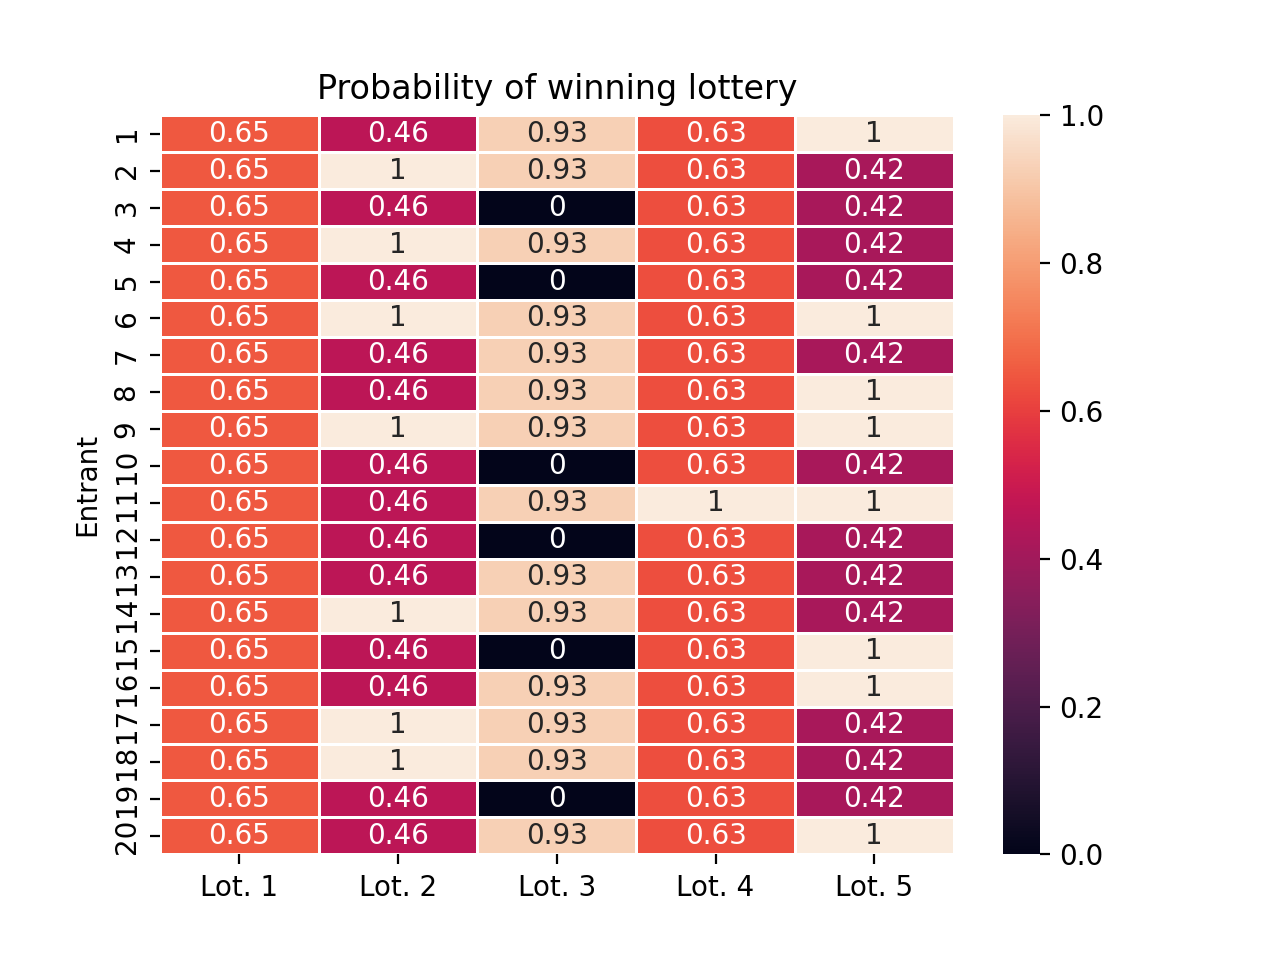

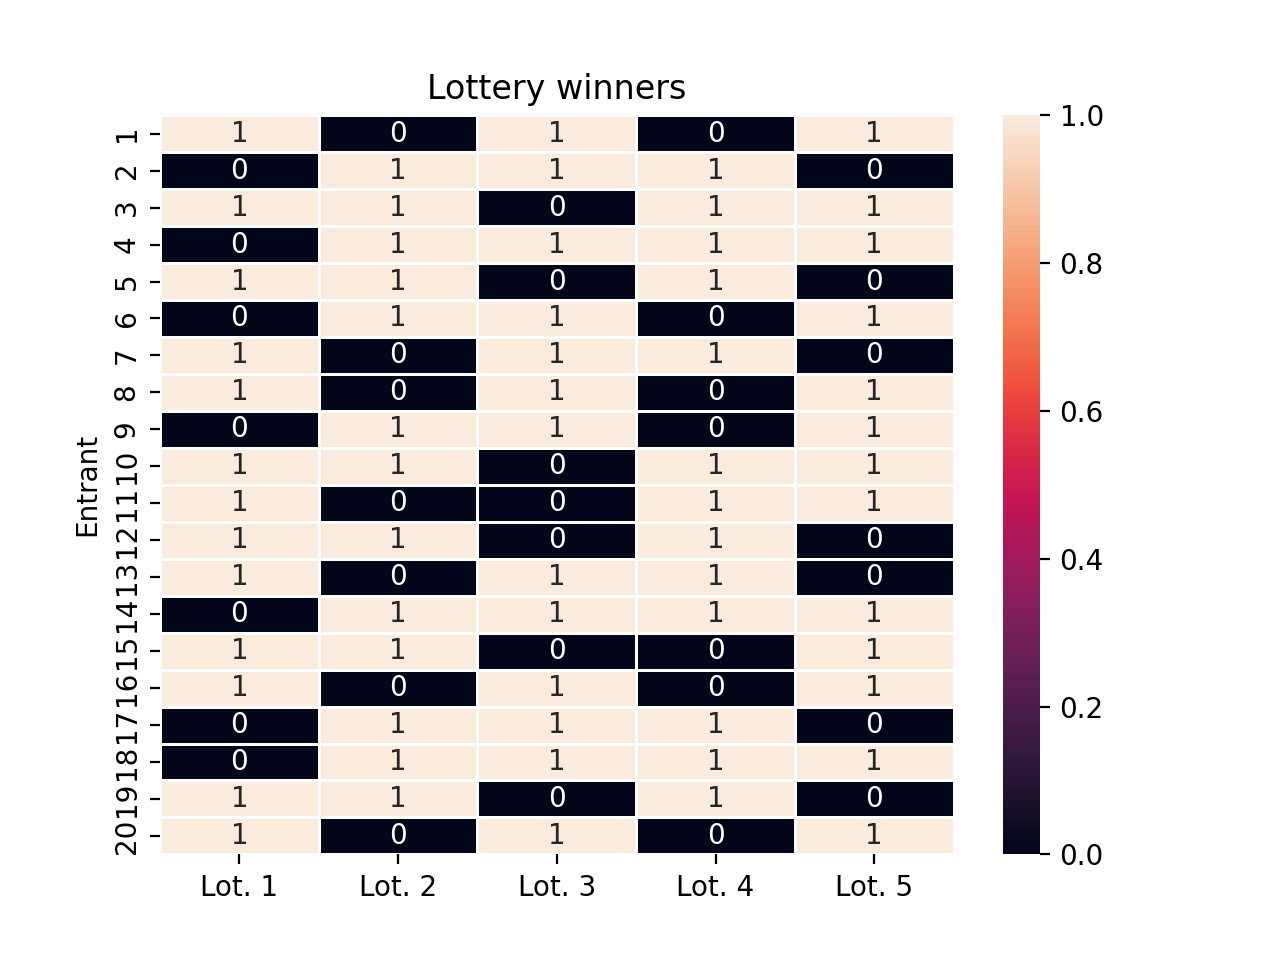

In [7]:
#| code-fold: true
#| warning: false
demo_pool = LotteryPool("Demonstration Pool")
scores = jnp.ones((20,))

# run five lotteries
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)

ax = demo_pool.plot_win_probabilities(annot=True)
ax.set(ylabel="Entrant", title="Probability of winning lottery")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(5)])
ax.set_yticklabels([f"{i + 1}" for i in range(20)])
plt.show()

ax = demo_pool.plot_winners(annot=True)
ax.set(ylabel="Entrant", title="Lottery winners")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(5)])
ax.set_yticklabels([f"{i + 1}" for i in range(20)])
plt.show()


Each column of the heatmap above corresponds to a lottery, and each row responds to an entrant. In the first column, we see that every entrant has the same chance of winning the lottery. In the second lottery, everyone who lost the first lottery is guaranteed a win, and entrants who won the first lottery have a low chance of winning again. In the third lottery, entrants who have won twice already are guaranteed to lose the lottery, but everyone else gets a fairly high change of winning for a second time.

One nice feature about this system is that once you know all the lottery scores, you can transparently tell each entrant their probability of winning the lottery, before actually running the lottery.

In this case, the lottery is in essence operating as a randomized turn-based system, where you have to wait for everyone to win before moving on to the next round. So why might we want to use this lottery system if it essentially boils down to taking turns with some randomness? 

## Example: non-uniform scores, varying entrants and varying lottery size

Things get more complicated when the entrants to each lottery change over time, when their scores vary, and when a different number of people can win each lottery. Below, we run three more lotteries in the same pool as before, adding five new lottery entrants and changing the number of winners per lottery.

/tmp/ipykernel_29520/747831739.py:24: RuntimeWarning: invalid value encountered in scalar divide


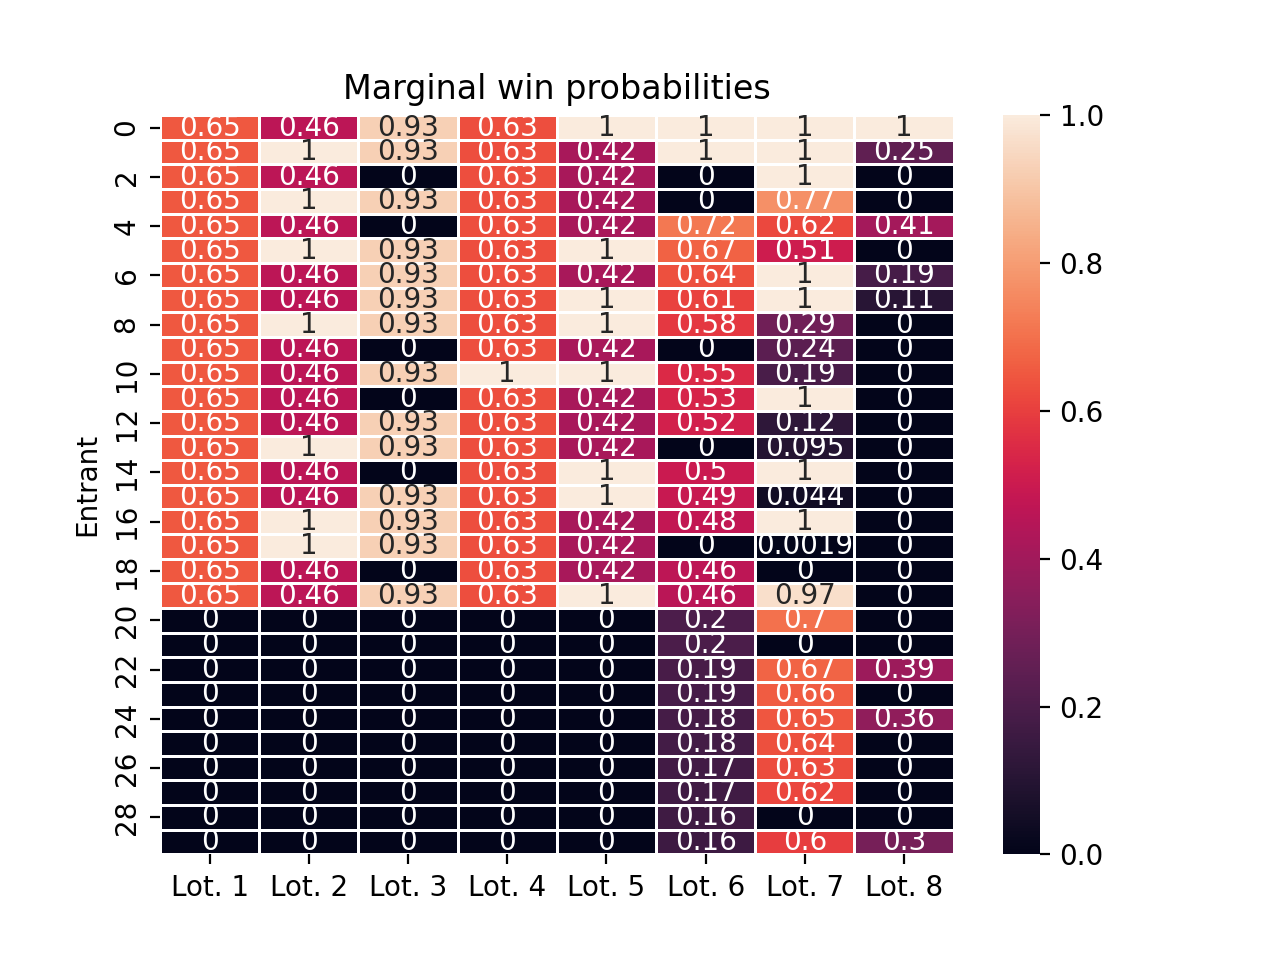

In [8]:
#| warning: false
#| code-fold: true

scores = jnp.ones((30,))
scores = jnp.array([1 / (i + 1)**0.5 for i in range(30)])
demo_pool.run_lottery(scores, lottery_size=11)
demo_pool.run_lottery(scores, lottery_size=17)
demo_pool.run_lottery(scores, lottery_size=3)

ax = demo_pool.plot_win_probabilities(annot=True)
ax.set(ylabel="Entrant", title="Marginal win probabilities")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(demo_pool.scores.shape[1])])
plt.show()

::: {.callout-note}
# First time lottery entrants
Whether or not first time lottery entrants are likely to win the lottery depends on the current state of the lottery when they enter. If there are many entrants in the lottery pool who have received fewer slots than they deserve, those entrants will be prioritized above the new entrants with equal scores. As the state of the lottery becomes more fair, the size of the lottery  (i.e., number of possible winners) increases, and the scores of new entrants increase, it becomes more and more likely that the new entrants will win a seat on their first entry.

As a lottery organizer, you could tune this behavior by boosting the scores of new entrants to the pool, making them more likely to win on a first entry, for instance.
:::

## Conclusion

There are also some extensions to this idea that make it more useful in real-world scenarios, like a waitlist, or a buddy system that ensures that pairs (or groups) of people either win together, or not at all. Buddy systems would be especially relevant in settings like over-subscribed sports leagues, where it's most fun to play on a team with your friends.

Regardless, I would love to see some events and organizations try this out. I think this kind of idea would be most ergonomically integrated into general event hosting systems or payment systems: for instance, [Eventbrite](https://www.eventbrite.com/) or [Square](https://stripe.com/) could attach purchases to repeated lottery pools. I'm especially curious about this kind of system as a replacement for items that sell out very quickly. For instance, slots in the Madison Ultimate Frisbee League are often filled within a day of going on sale, creating unpleasant and stressful races to purchase the tickets in time. I would rather have a week to unhurried enter a lottery for these slots, and then at the end of the week learn if I got one. I'm not sure how the economics of this would work out for businesses, but imagining paying a small amount to enter the lottery, which is applied toward the cost of your purchase if you win.

## Appendix: making sense of the optimization problem {.appendix}

To understand how the lottery system works, I found the following visualizations particularly helpful. The core idea is that scores and lottery size determine the number of seats each entrant deserves win in a given lottery. The first step is to track how these allocation portions of winner seats evolve over time. For the lotteries above, they evolve as follows.

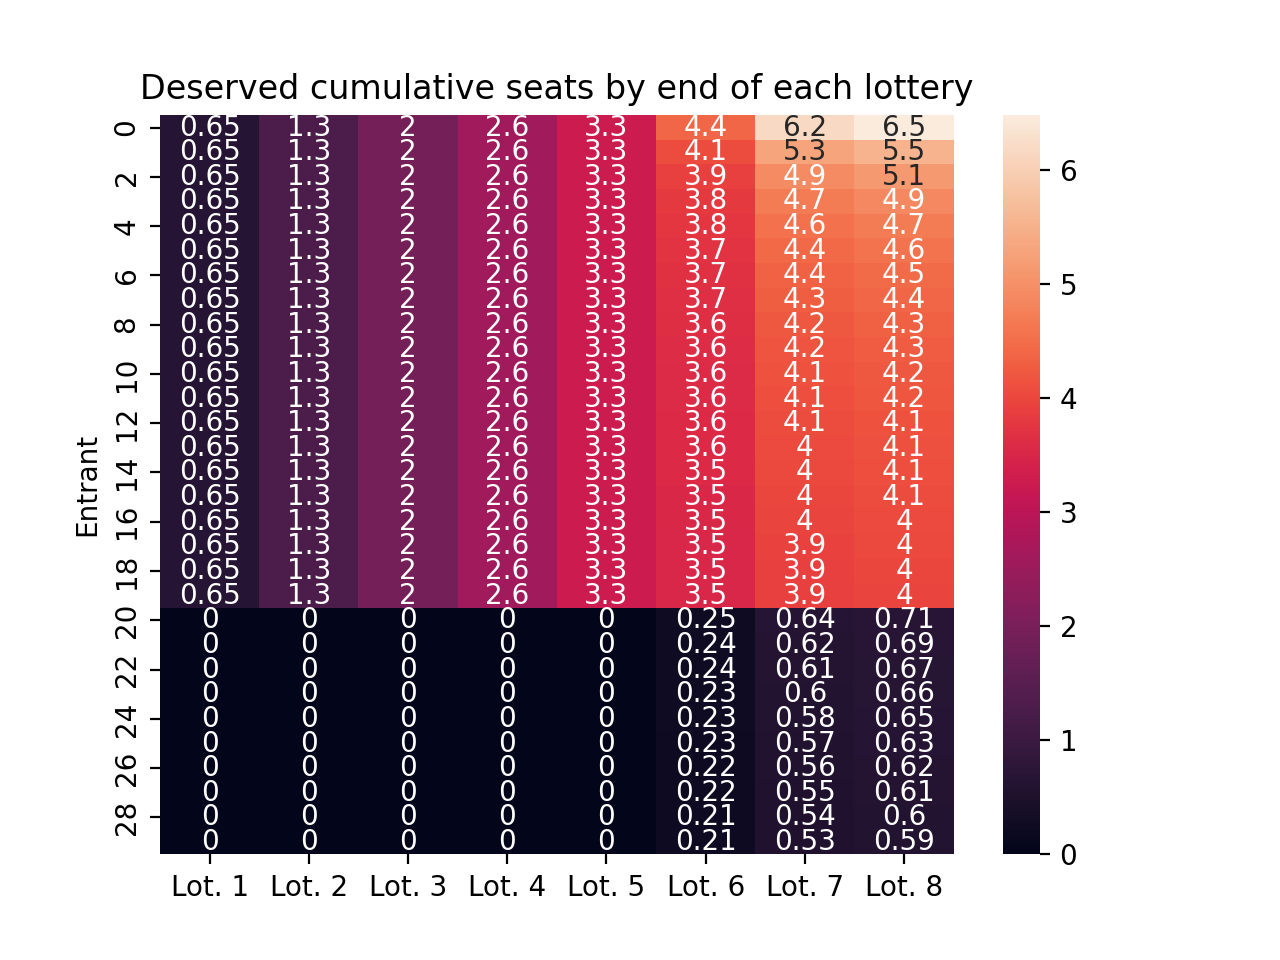

In [9]:
#| code-fold: true

deserved_seats = (
    demo_pool.scores / demo_pool.scores.sum(axis=0) * demo_pool.lottery_sizes
).cumsum(axis=1)

ax = sns.heatmap(
    deserved_seats,
    annot=True
)
ax.set(title="Deserved cumulative seats by end of each lottery", ylabel="Entrant")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(demo_pool.scores.shape[1])])
plt.show()

The next key idea is to track how many times each person has won already, and compare that with the seats they deserved in the past and in the current lottery. These individual deviations from fair outcomes will guide our choice of lottery probabilities for the current lottery. In the following, negative numbers indicate entrants who has received fewer winning seats than they were allocated. Positive numbers indicated entrants who have received more winner seats than they were allocated. Hopefully it's clear that we want to start by assigning current lottery win probabilities to the folks who have received the least fair outcomes so fair.

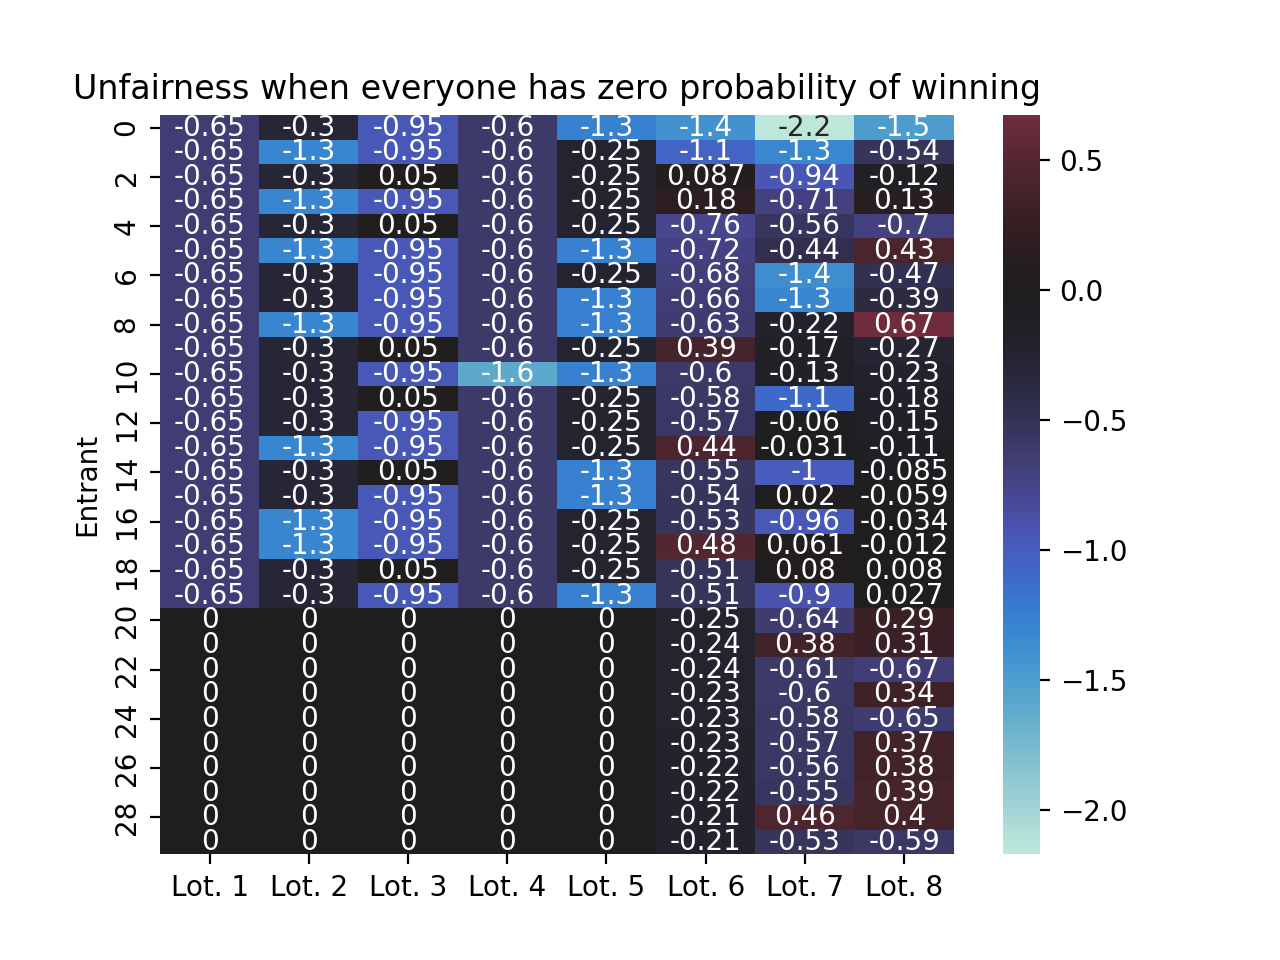

In [10]:
#| code-fold: true

ax = sns.heatmap(
    demo_pool.winners.cumsum(axis=1) - demo_pool.winners - deserved_seats,
    annot=True,
    center=0
)
ax.set(title="Unfairness when everyone has zero probability of winning", ylabel="Entrant")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(demo_pool.scores.shape[1])])
plt.show()

We calculate that the win probabilities that would make things most fair are as follows. Note that the number of lottery winners is changing over time (the size of each lottery is shown in parentheses under the lottery index). I recommend comparing the figure above with the figure below, and seeing who is getting assigned win probability in each lottery. This is what convinced me that I had found the right objective function.

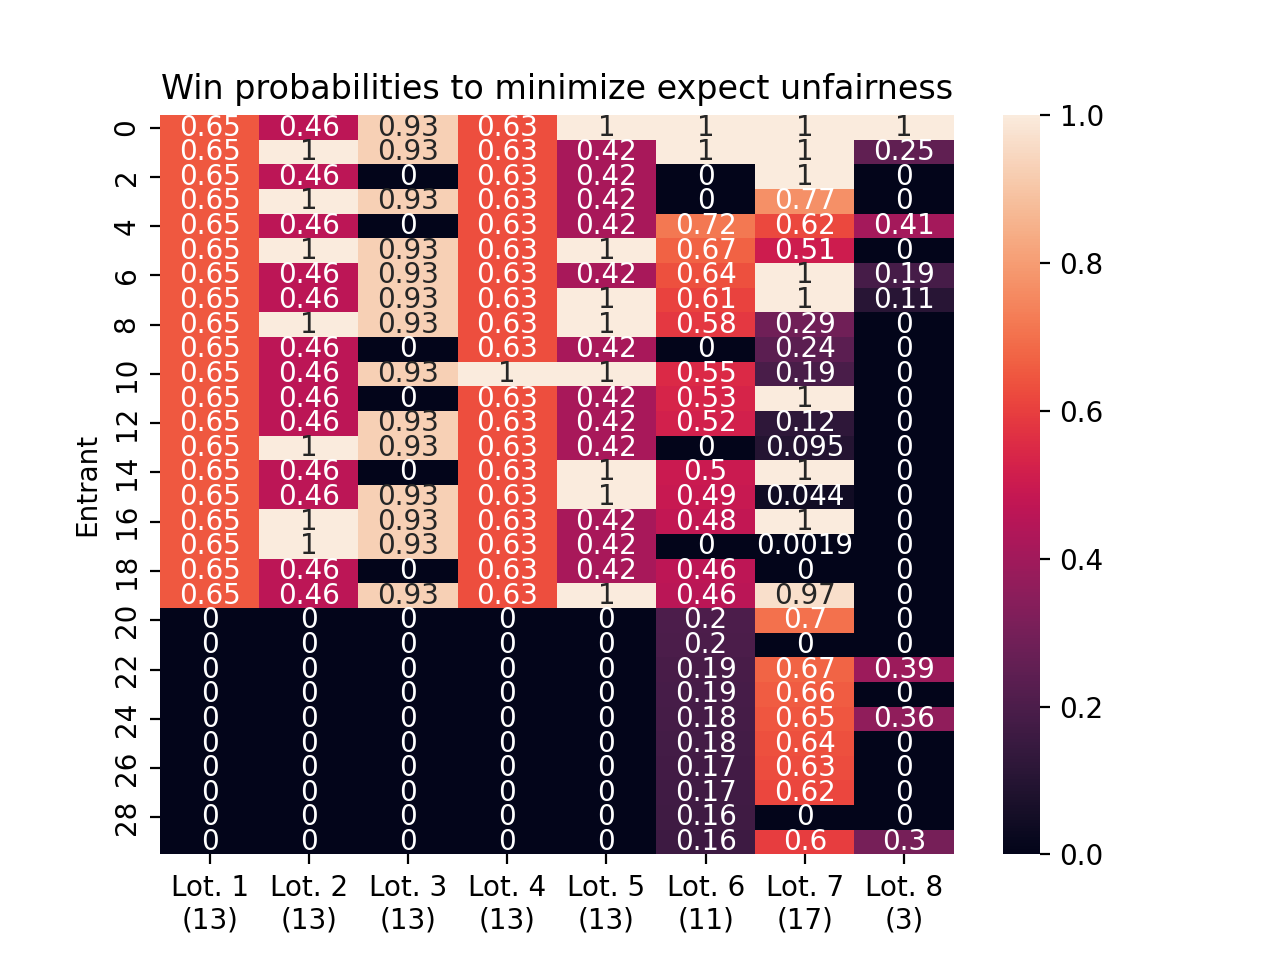

In [16]:
#| code-fold: true

ax = sns.heatmap(
    demo_pool.win_probabilities,
    annot=True
)
ax.set(title="Win probabilities to minimize expect unfairness", ylabel="Entrant")
ax.set_xticklabels([f"Lot. {i + 1}\n({size})" for i, size in enumerate(demo_pool.lottery_sizes)])
plt.show()

If you add the previous two figures together, that tells you what you expect the unfairness levels to be, on average, after running the current lottery.

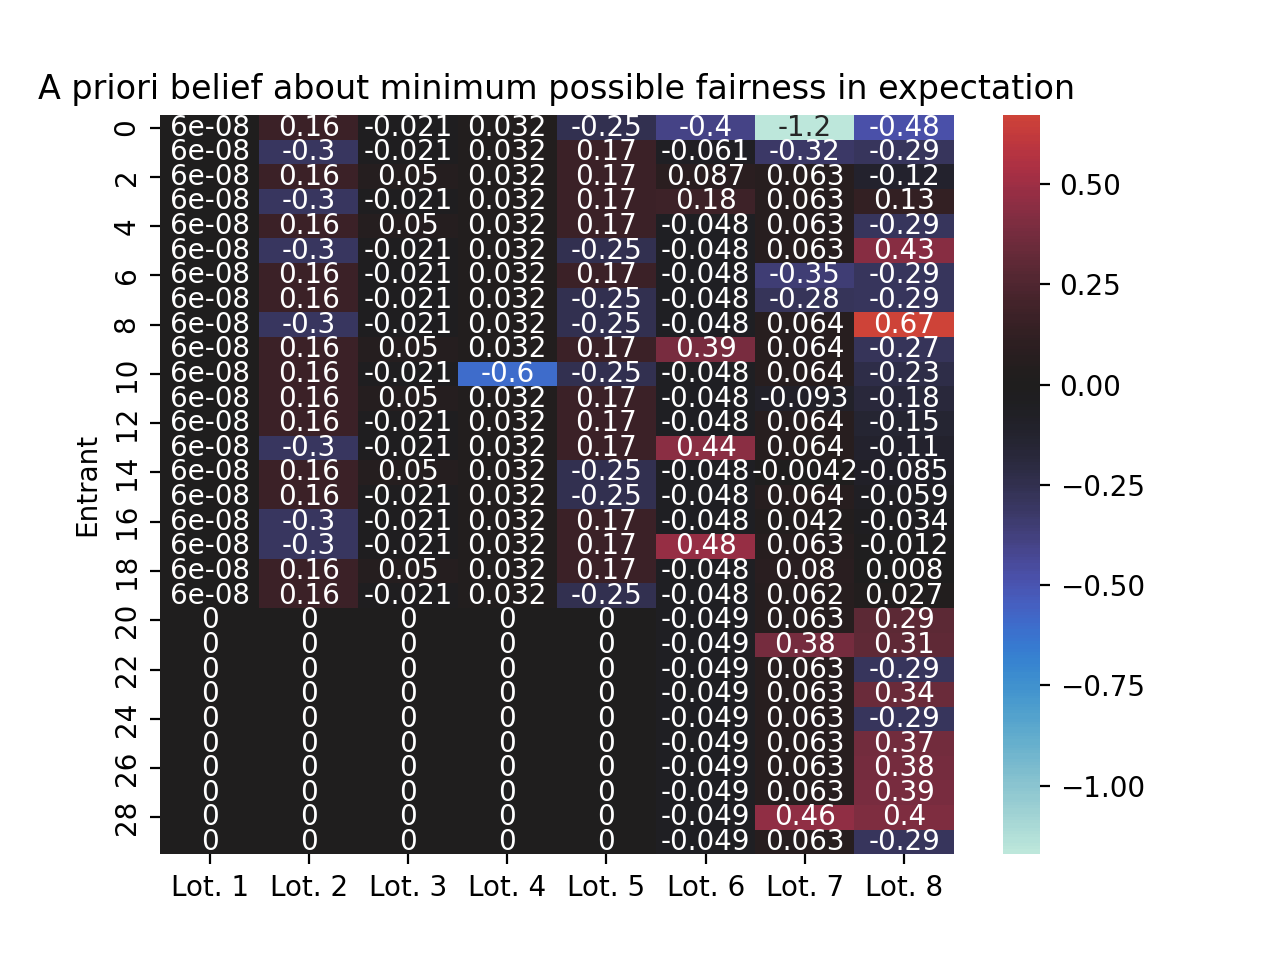

In [12]:
#| code-fold: true

ax = sns.heatmap(
    demo_pool.winners.cumsum(axis=1) - demo_pool.winners - deserved_seats + demo_pool.win_probabilities,
    annot=True,
    center=0
)
ax.set(title="A priori belief about minimum possible fairness in expectation", ylabel="Entrant")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(demo_pool.scores.shape[1])])
plt.show()

In practice, however, the lottery is random, and so the unfairness after each lottery is also random. Here's what it looked like in our case.

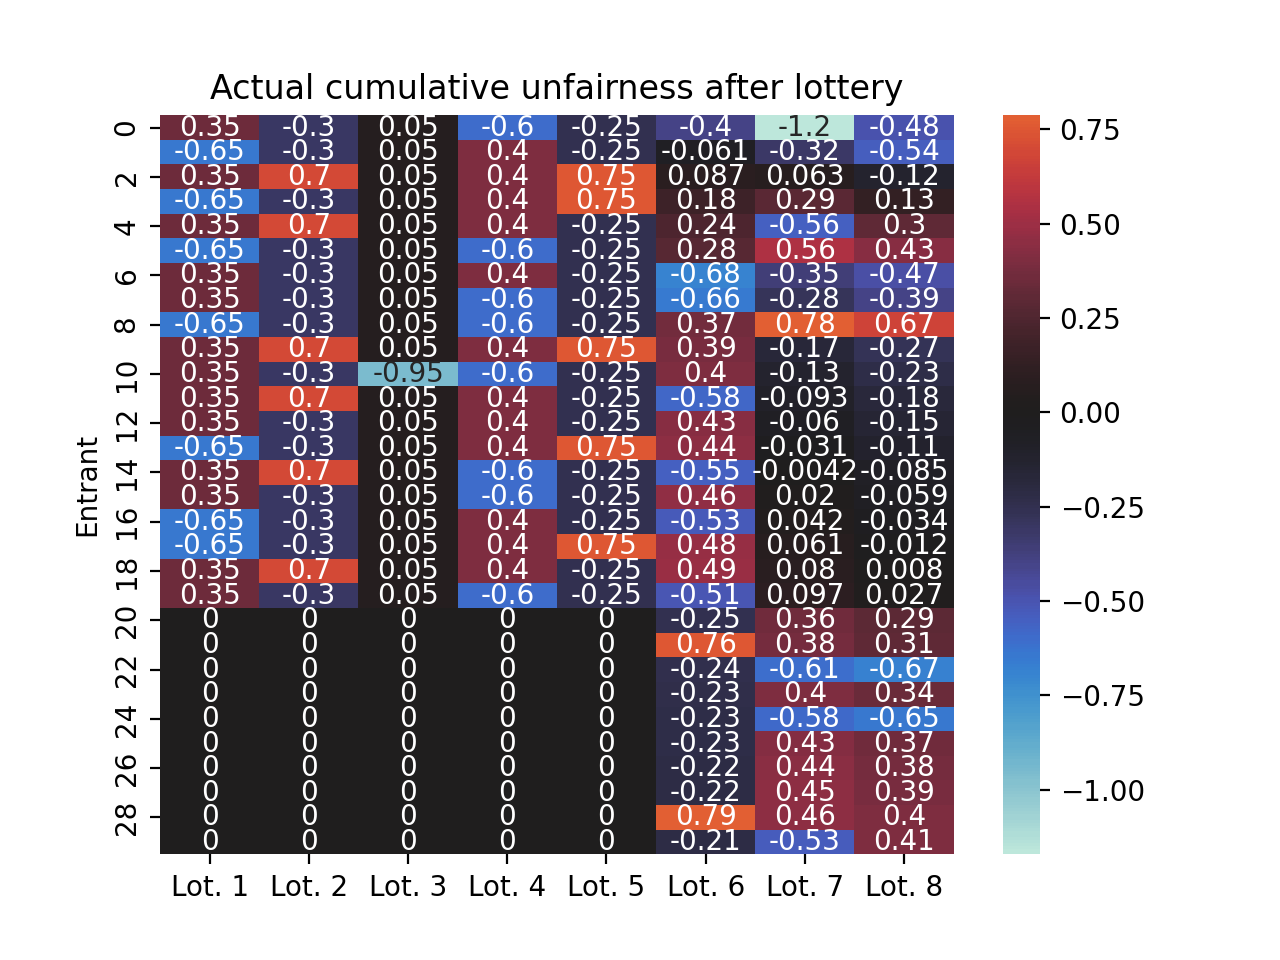

In [13]:
#| code-fold: true

ax = sns.heatmap(
    demo_pool.winners.cumsum(axis=1) - deserved_seats,
    annot=True,
    center=0
)
ax.set(title="Actual cumulative unfairness after lottery", ylabel="Entrant")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(demo_pool.scores.shape[1])])
plt.show()

We can also visualize the number of times each entrant has won the lottery at each point in time.

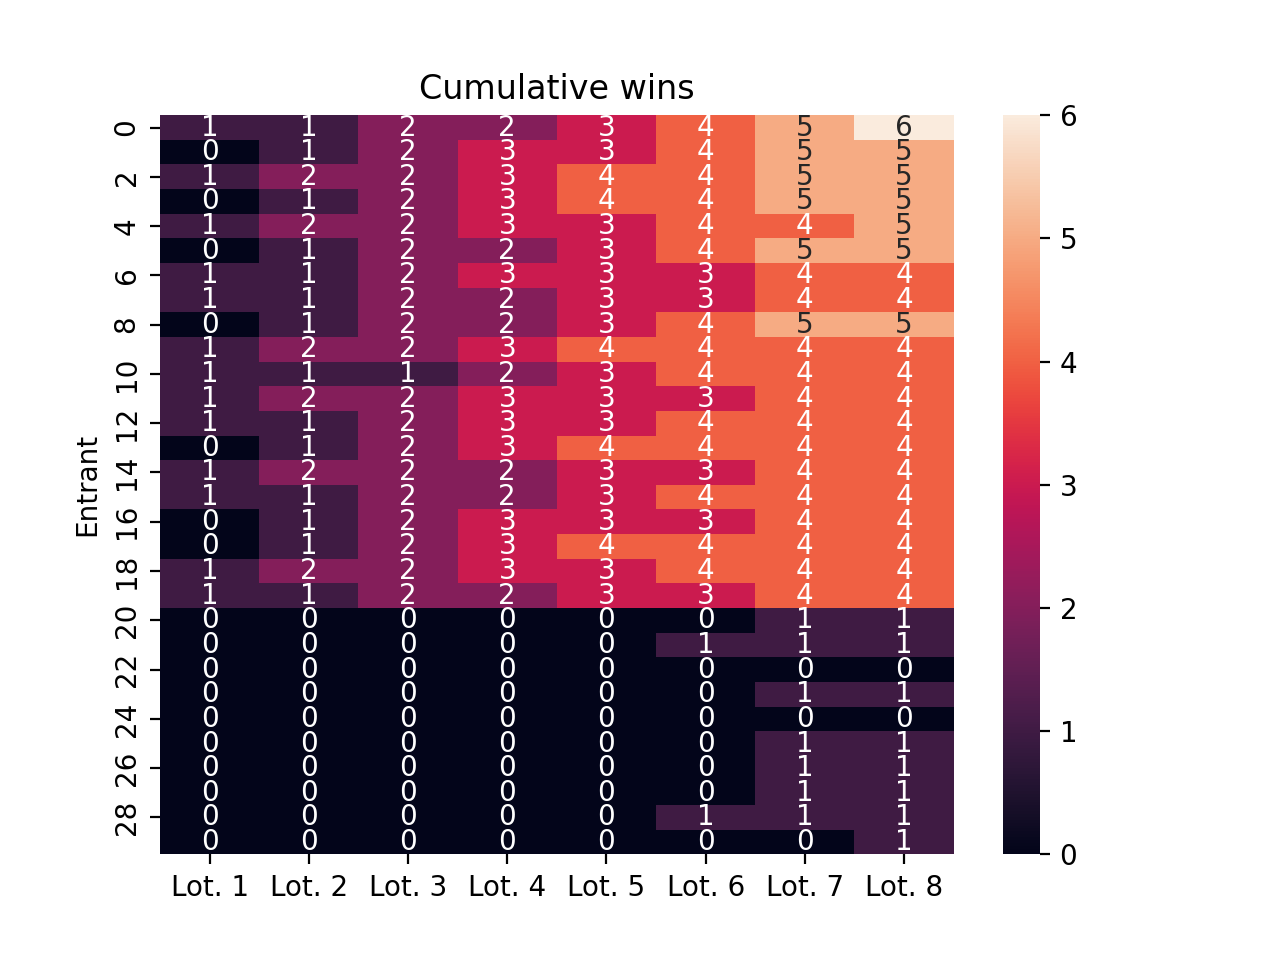

In [14]:
#| code-fold: true

ax = sns.heatmap(
    demo_pool.winners.cumsum(axis=1),
    annot=True
)
ax.set(title="Cumulative wins", ylabel="Entrant")
ax.set_xticklabels([f"Lot. {i + 1}" for i in range(demo_pool.scores.shape[1])])
plt.show()